In [1]:
import numpy as np
import re
import mne
import random
import glob
import os
import wfdb
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt

### Create dataset with a more balanced seizure and non-seizure class sample

1. "more_balanced_signals.npy": Contains EEG signal data with 10-second windows for each sample.
2. "more_balanced_labels.npy": Corresponding labels for the EEG signal data, where 1 indicates seizure and 0 indicates non-seizure.

In [2]:
# Each directory is assigned an integer ranging from 0 to 24. There are 23 patients.
# 22 have a single directory, and 1 has two directories.
# Retrieve the assigned directory numbers from the files.

path = r'data\raw_data\chb-mit-scalp-eeg-database-1.0.0'
data_folders = sorted(glob.glob(os.path.join(path, '*[0-9]')))

def file_id(folder):
    return [ name[-2:] for name in [file.rsplit('\\',2)[-1] for file in folder]]
print("Case ID: ")
print(file_id(data_folders))

Case ID: 
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [3]:

class EdfToNpy:
    # Constants
    WINDOW_TIME = 10  # segment size in seconds
    STEP_TIME = 5     # Step size in seconds
    SEIZURE_PROPORTION = 0.005    # proportion of non-seizure
    TO_MICROVOLTS = 1e6
    channel_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                      'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                      'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

    def __init__(self, folder, save_to):
        self.save_to = save_to
        self.folder = folder

    def bandpass_filter(self, data, lowcut=0.5, highcut=50.0, fs=256.0, order=5):
        """
        Applies a bandpass filter to the input data.

        Parameters:
        data (array): The input EEG signal data.
        lowcut (float): The lower cutoff frequency for the filter in Hz.
        highcut (float): The upper cutoff frequency for the filter in Hz.
        fs (float): The sampling frequency of the data in Hz.
        order (int): The order of the Butterworth filter.

         Returns:
        array: The filtered EEG data.
        """
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=-1)

    def read_edf(self):
        """
        Processes EDF files to extract EEG data and calculate seizure proportions.

        Returns:
        count (int): The total number of EEG windows processed.
        num_channels (int): The total number of EEG channels.
        window_size (int): The size of the window in data points.
        """
        count = 0  # initialize the count variable
        window_size = 0  # initialize the window_size variable

        for file in self.folder:
            edf_data = mne.io.read_raw_edf(file, preload=False)
            edf_labels = edf_data.ch_names

            # Validate channel labels

            if sum([any([0 if re.match(c, l) is None else 1 for l in edf_labels]) for c in EdfToNpy.channel_labels]) == len(EdfToNpy.channel_labels):
                sampling_freq = int(1 / (edf_data.times[1] - edf_data.times[0]))
                window_size = sampling_freq * EdfToNpy.WINDOW_TIME
                window_stride = sampling_freq * EdfToNpy.STEP_TIME

                # Seizure annotation handling

                has_seizure = np.zeros((edf_data.n_times,))
                if os.path.exists(file + '.seizures'):
                    has_annotation = wfdb.rdann(file, 'seizures')
                    for idx in range(int(has_annotation.sample.size / 2)):
                        has_seizure[has_annotation.sample[idx * 2]:has_annotation.sample[idx * 2 + 1]] = 1

                # Calculate seizure proportions in sliding windows

                has_seizure_idx = np.array([has_seizure[idx * window_stride:idx * window_stride + window_size].sum() / window_size for idx in range((edf_data.n_times - window_size) // window_stride)])

                # Calculate non-seizure and seizure window counts

                noseizure_n_size = round(EdfToNpy.SEIZURE_PROPORTION * np.where(has_seizure_idx == 0)[0].size)
                seizure_n_size = np.where(has_seizure_idx > 0)[0].size
                count = count + noseizure_n_size + seizure_n_size  # increment count to tally total samples

            edf_data.close()

        return count, len(EdfToNpy.channel_labels), window_size

    def extract_edf(self, n_samples, n_channel_labels, window_size):
        """
        Extracts EEG signals and labels from EDF files, processes them, and saves the data as NumPy arrays.

        Parameters:
        n_samples (int): The total number of samples to process.
        n_channel_labels (int): The number of EEG channels.
        window_size (int): The size of the window in data points.

        Saves:
        _signals.npy: Processed EEG signals.
        _labels.npy: Corresponding seizure and non-seizure labels.
        """
        signals_np = np.zeros((n_samples, n_channel_labels, window_size), dtype=np.float32)
        labels_np = np.zeros(n_samples, dtype=np.int32)
        count = 0  # initialize count variable

        for number, file in enumerate(self.folder):
            edf_data = mne.io.read_raw_edf(file, preload=False)

            # Check for matching channel labels

            n_label_match = sum([any([0 if re.match(ch, ch_name) is None else 1 for ch_name in edf_data.ch_names]) for ch in EdfToNpy.channel_labels])
            if n_label_match == len(EdfToNpy.channel_labels):
                # Rename channels to standardised labels
                dict_ch_name = {sorted([ch_name for ch_name in edf_data.ch_names if re.match(ch, ch_name) is not None])[0]: ch for ch in EdfToNpy.channel_labels}
                edf_data.rename_channels(dict_ch_name)

                has_seizure = np.zeros((edf_data.n_times,))
                signals_ = edf_data.get_data(picks=EdfToNpy.channel_labels) * EdfToNpy.TO_MICROVOLTS

                # Apply bandpass filter to clean the signal
                signals_ = np.array([self.bandpass_filter(signal) for signal in signals_])

                # Process seizure annotations if available

                if os.path.exists(file + '.seizures'):
                    has_annotation = wfdb.rdann(file, 'seizures')
                    for idx in range(int(has_annotation.sample.size / 2)):
                        has_seizure[has_annotation.sample[idx * 2]:has_annotation.sample[idx * 2 + 1]] = 1

                # Calculate seizure proportions and windows

                sampling_freq = int(1 / (edf_data.times[1] - edf_data.times[0]))
                window_size = sampling_freq * EdfToNpy.WINDOW_TIME
                window_stride = sampling_freq * EdfToNpy.STEP_TIME
                has_seizure_idx = np.array([has_seizure[idx * window_stride:idx * window_stride + window_size].sum() / window_size for idx in range((edf_data.n_times - window_size) // window_stride)])

                # Select random non-seizure windows

                noseizure_n_size = round(EdfToNpy.SEIZURE_PROPORTION * np.where(has_seizure_idx == 0)[0].size)

                # Non-seizure data (random sampling)
                temp_negative = random.sample(list(np.where(has_seizure_idx == 0)[0]), noseizure_n_size)
                for value in temp_negative:
                    start_index = value * window_stride
                    stop_index = value * window_stride + window_size
                    signals_np[count, :, :] = signals_[:, start_index:stop_index]
                    labels_np[count] = 0
                    count = count + 1

                # Seizure data
                temp_positive = list(np.where(has_seizure_idx > 0)[0])
                for value in temp_positive:
                    start_index = value * window_stride
                    stop_index = value * window_stride + window_size
                    signals_np[count, :, :] = signals_[:, start_index:stop_index]
                    labels_np[count] = 1
                    count = count + 1
            else:
                print(f"Unable to read {file}")

            edf_data.close()

        # Save the processed data
        np.save(self.save_to + '_signals', signals_np)
        np.save(self.save_to + '_labels', labels_np)

    def show_eeg(self, signals, label=None):
        """
        Visualises EEG signals by plotting each channel vertically with an offset for easier differentiation.

        Parameters:
        signals (array): A NumPy array containing EEG signal data
        """
        # Define vertical spacing between channels in the plot
        vertical_width = 250

        # Sampling frequency of the EEG signal in Hz
        fs = 256

        # Create a new figure and axis for the plot

        fig, ax = plt.subplots()
        for i in range(signals.shape[0]):
            # Plot the signal for the current channel with time on the x-axis
            ax.plot(np.arange(signals.shape[-1]) / fs, signals[i, :] + i * vertical_width, linewidth=0.5, color='tab:blue')
            # Annotate the channel label next to its corresponding signal
            ax.annotate(EdfToNpy.channel_labels[i], xy=(0, i * vertical_width))

        # Add plot title based on label
        if label is not None:
            title = "Seizure" if label == 1 else "Non-Seizure"
            ax.set_title(f"EEG Sample - {title}", fontsize=14)

        # Invert the y-axis so that the topmost channel appears first
        ax.invert_yaxis()
        plt.xlabel("Time (s)")
        plt.show()

In [4]:
# Verify that NumPy files are readable.
# Retrieve all EDF files contained within the parent folder: "data_folders".

all_edf = [ file for folder in data_folders for file in glob.glob(folder + '/*.edf')]
print(f"Total number of files is {len(all_edf)}")

Total number of files is 686


In [ ]:
# Execution time: approximately 8-9 minutes to complete the cell.
# Instantiate the class to process EDF files.
data_npy = EdfToNpy(all_edf, 'more_balanced')

# Export all EDF file data into a single NumPy file, with 10-second windows per sample:
# - "10sec_signals.npy": Contains processed EEG signals.
# - "10sec_labels.npy": Contains corresponding annotations, where 1 indicates seizure and 0 indicates non-seizure.
# Each label corresponds to its associated signal sample.

# Extract relevant data from the EDF files.
sample_length, channel_length, window_length = data_npy.read_edf()
data_npy.extract_edf(sample_length, channel_length, window_length)

#### show file shape

In [6]:
# Verify that NumPy files are readable and contain the expected data.
# Define the file paths for signals and labels.
path_signal = 'more_balanced_signals.npy'
path_label = 'more_balanced_labels.npy'

# Check if both signal and label files exist.
if os.path.exists(path_signal) and os.path.exists(path_label):
    full_data = np.load(path_signal)
    full_labels = np.load(path_label)

    # Retrieve unique labels and their respective counts.

    unique, count = np.unique(full_labels, return_counts=True)

    # Display the label distribution and data shapes.

    print(f"Labels contain {count[0]} non-seizure samples and {count[1]} seizure samples")
    print(f"Data shape is {full_data.shape}")
    print(f"Labels' shape is {full_labels.shape}")

Labels contain 3558 non-seizure samples and 2606 seizure samples
Data shape is (6164, 23, 2560)
Labels' shape is (6164,)



#### Summary table for `more_balanced_labels.npy`:

| **File Name**               | **Non-Seizure Samples (0)** | **Seizure Samples (1)** | **Total Samples** |
|------------------------------|-----------------------------|--------------------------|--------------------|
| `more_balanced_labels.npy`   | 3558                        | 2606                     | 6164               |

---
#### Summary of all 10-second long context window datasets

#### Combined Table from `edf_to_numpy.ipynb` and `EdfToNumpy2.ipynb` notebooks.

| **File Name**               | **Non-Seizure Samples (0)** | **Seizure Samples (1)** | **Total Samples** |
|------------------------------|-----------------------------|--------------------------|--------------------|
| `train_10sec_labels.npy`     | 9190                        | 119                      | 9309               |
| `test_10sec_labels.npy`      | 2307                        | 186                      | 2493               |
| `10sec_labels.npy`           | 6744                        | 2606                     | 9350               |
| `more_balanced_labels.npy`   | 3558                        | 2606                     | 6164               |



#### Visualization of EEG Sample from CHB-MIT Dataset

This cell demonstrates how to visualize a 10-second EEG window using the `show_eeg` method of the `EdfToNpy` class. The visualization displays 23 EEG channels vertically offset for clarity. Both seizure and non-seizure examples can be plotted using the corresponding labels.


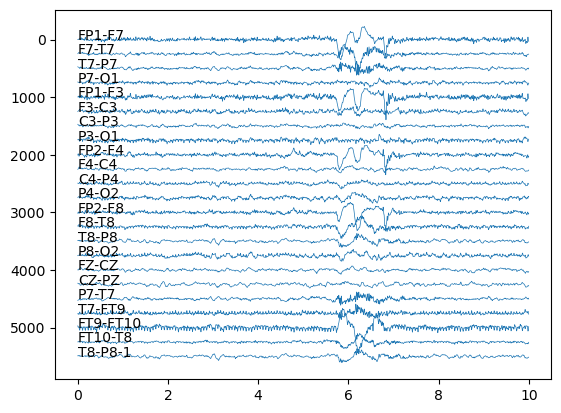

In [5]:
# Load the processed EEG signals and labels
signals = np.load("more_balanced_signals.npy")
labels = np.load("more_balanced_labels.npy")

# Create an instance of EdfToNpy (folder and save path not used for plotting)
eeg_plotter = EdfToNpy(folder=[], save_to="")

# Show one random example
eeg_plotter.show_eeg(signals[0])


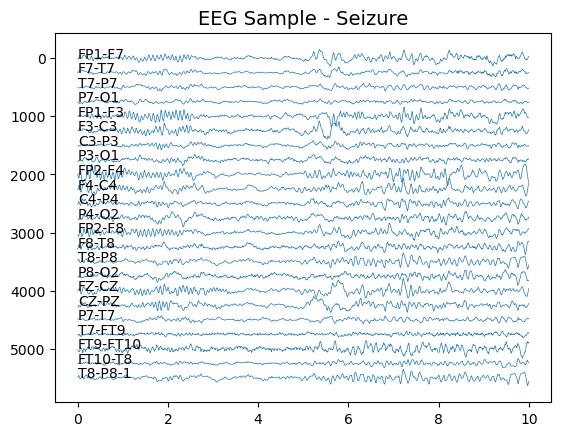

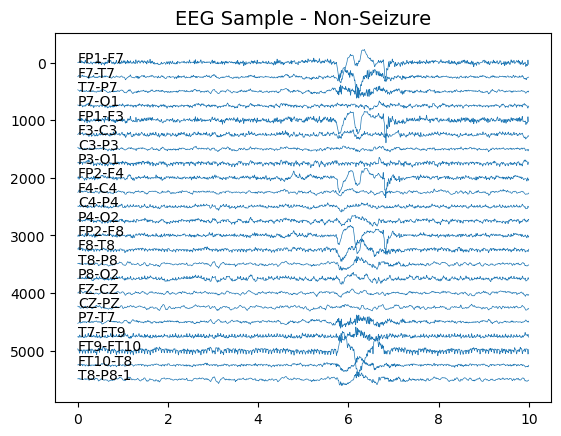

In [6]:
# Show a seizure example
seizure_idx = np.where(labels == 1)[0][0]
eeg_plotter.show_eeg(signals[seizure_idx], label=1)

# Show a non-seizure example
nonseizure_idx = np.where(labels == 0)[0][0]
eeg_plotter.show_eeg(signals[nonseizure_idx], label=0)


#### END